In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
# Import class
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import pandas as pd

stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\User\Desktop\nba_stats\Data\nba_stats.pickle


In [2]:
from scipy.stats import ttest_ind

In [3]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

# Playing at home
Quick easy analysis to see how much an effect playing at home has.

Home advantage of -1.64 with p-value 0.102


Text(0.5, 1.0, 'Steph Curry')

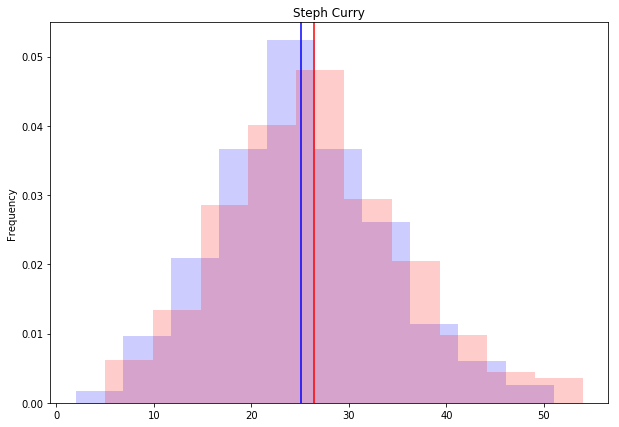

In [4]:
player_id = nba_stats.get_player_name_id_dict()['Stephen Curry']
stat = 'PTS'

df_player = player_df_convert_numeric(nba_stats.get_player_stats()[player_id].copy())
df_player = df_player[df_player['MIN'] > 0]
df_home = df_player[df_player['HOME_AWAY'] == 'HOME']
df_away = df_player[df_player['HOME_AWAY'] == 'AWAY']

# Find stats
home_stats = df_home[stat]
away_stats = df_away[stat]

home_adv, p_value = ttest_ind(home_stats, away_stats)
print('Home advantage of {:.2f} with p-value {:.3f}'.format(home_adv, p_value))

# Graph
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
df_home[stat].plot(kind='hist', alpha=0.2, color='blue', ax=ax, density=True)
df_away[stat].plot(kind='hist', alpha=0.2, color='red', ax=ax, density=True)
ax.axvline(x=home_stats.mean(), color='blue')
ax.axvline(x=away_stats.mean(), color='red')
ax.set_title('Steph Curry')

## Repeat analysis for all players
It doesn't seem like Stephen Curry is particularly affected by home court advantage. He scores just as much (if not more) when he's on the road! Repeat this analysis for all other players in the database and see if there's any overwhelming trend. I suspect that players would play better at home court due to the favourable atmosphere.

In [5]:
def player_home_away_ttest(player_id, stat):
    ''' Run t test for specific player and stat. Returns home overs and p-value '''
    df_player = player_df_convert_numeric(nba_stats.get_player_stats()[player_id].copy())
    df_player = df_player[df_player['MIN'] > 0]
    df_home = df_player[df_player['HOME_AWAY'] == 'HOME']
    df_away = df_player[df_player['HOME_AWAY'] == 'AWAY']

    # Find stats
    home_stats = df_home[stat]
    away_stats = df_away[stat]

    if len(home_stats) > 1 and len(away_stats) > 1:
        # Can only conduct test if ast least 2 obsservations in each sample
        t_stat, p_value = ttest_ind(home_stats, away_stats)
    else:
        return None, None
    
    home_overs = home_stats.mean() - away_stats.mean()
    
    return home_overs, p_value

In [6]:
def home_away_ttest(stat):
    ''' Run player t test for all players and return a dataframe of their name, home advantage, and p-value'''
    df = pd.DataFrame()
    for player in nba_stats.get_player_name_id_dict().keys():
        player_id = nba_stats.get_player_name_id_dict()[player]
        
        home_overs, p_value = player_home_away_ttest(player_id, stat)
        df_player = pd.DataFrame({'player':[player], 'Stat':[stat], 
                                 'home_mean_overs':[home_overs], 'p_value': [p_value]})
        df = df.append(df_player)
        
    return df

In [7]:
df_home_adv_pts = home_away_ttest('PTS')
df_home_adv_reb = home_away_ttest('REB')
df_home_adv_ast = home_away_ttest('AST')

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Text(0.5, 1.0, 'PTS\n0.073 proportion of p values under 0.05')

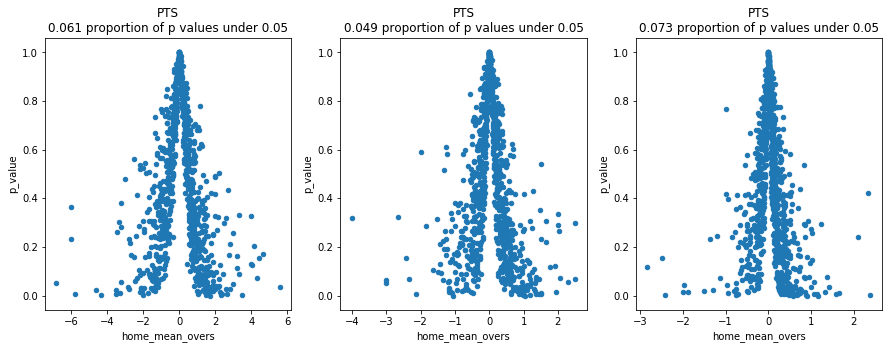

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df_home_adv_pts.plot.scatter(x='home_mean_overs', y='p_value', ax=ax[0])
fr_sig = (df_home_adv_pts['p_value']<0.05).sum()/float(len(df_home_adv_pts))
ax[0].set_title('PTS\n{:.3f} proportion of p values under 0.05'.format(fr_sig))

df_home_adv_reb.plot.scatter(x='home_mean_overs', y='p_value', ax=ax[1])
fr_sig = (df_home_adv_reb['p_value']<0.05).sum()/float(len(df_home_adv_reb))
ax[1].set_title('PTS\n{:.3f} proportion of p values under 0.05'.format(fr_sig))

df_home_adv_ast.plot.scatter(x='home_mean_overs', y='p_value', ax=ax[2])
fr_sig = (df_home_adv_ast['p_value']<0.05).sum()/float(len(df_home_adv_ast))
ax[2].set_title('PTS\n{:.3f} proportion of p values under 0.05'.format(fr_sig))

# Conclusion
Surprisingly, doesn't seem to be much evidence of a home team advantage. Wonder if this is different for team wins.

# Home court advantage for teams
There are plenty of articles and analyses conducted to show that home court advantage is quite significant in the NBA. And especially for teams such as Utah and Denver which are hard to get to and have a high altitude visiting teams aren't as used to. I'm just going to do a quick analysis to confirm.

In [9]:
from statsmodels.stats.proportion import proportions_ztest

test stat of 15.761618390173574 and p-value of 5.7150518610883055e-56


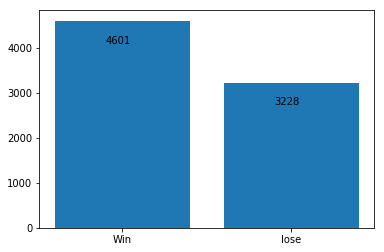

In [10]:
df_home_games = nba_stats.get_games()[nba_stats.get_games()['HOME_AWAY'] == 'HOME']
df_home_games = df_home_games[~df_home_games.duplicated()]

n_win = (df_home_games['WL'] == 'W').sum()
n_lose = (df_home_games['WL'] == 'L').sum()

assert len(df_home_games) == n_win + n_lose

counts = [n_win, n_lose]

plt.bar(x=[0, 1], height=counts)
plt.xticks([0, 1], ['Win', 'lose'])
for i, height in enumerate(counts):
    plt.text(x=i-0.1, y=height - 500, s=height)

test_stat, pval = proportions_ztest(n_win, n_win + n_lose, 0.5)
print('test stat of {} and p-value of {}'.format(test_stat, pval))

# Conclusion
Clearly, home court has an advantage. It would be interesting to break this down across seasons

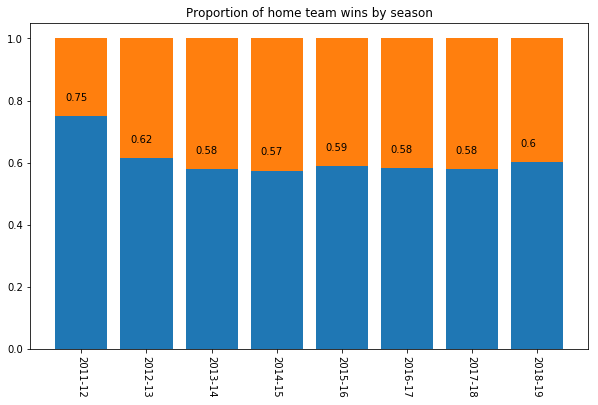

In [11]:
df_home_games['HOME_WIN'] = df_home_games['WL'].apply(lambda wl: 1 if wl == 'W' else 0)
df_home_games.head()

df_home_wins_per_season = df_home_games[['SEASON_YEAR', 'HOME_WIN']].groupby(by='SEASON_YEAR').mean()
df_home_wins_per_season['HOME_LOSE'] = df_home_wins_per_season['HOME_WIN'].apply(lambda win: 1-win)

fig = plt.figure(figsize=(10, 6))
plt.bar(df_home_wins_per_season.index, df_home_wins_per_season['HOME_WIN'])
plt.bar(df_home_wins_per_season.index, df_home_wins_per_season['HOME_LOSE'],
       bottom=df_home_wins_per_season['HOME_WIN'])
plt.xticks(rotation=-90)
plt.title('Proportion of home team wins by season')

for i, prop in enumerate(df_home_wins_per_season['HOME_WIN']):
    plt.text(i-0.25, prop + 0.05, round(prop,2))

Seems like the home court advantage stays pretty consistent across seasons